<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-review-tsne/blob/master/Amazon_Fine_Food_Reviews_Analysis_TSNE_per_30_iter_5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir kaggle
!ls
!pwd

kaggle	sample_data
/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
files.upload()

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 99% 249M/251M [00:03<00:00, 45.3MB/s]
100% 251M/251M [00:03<00:00, 80.2MB/s]


In [7]:
!ls
!unzip amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data



amazon-fine-food-reviews.zip  drive  kaggle  kaggle.json  sample_data
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


In [8]:
!ls amazon_fine_food_reviews_data/

database.sqlite  hashes.txt  Reviews.csv


# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [0]:
'''For the following t-SNE visualisation we are using following configuration values'''

learningrate = 200
iterations = 5000
totaldatapoints = 5000
perplexity =30

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [11]:

# using the SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""",con)# WHERE Score != 3 LIMIT 3000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [13]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [14]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [15]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [16]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [18]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

In [19]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.29901100176971

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [20]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [22]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()



#Will use only 5000 data points for TSNE visualization as my computer is low on RAM

posfinal = final[final['Score'] == 1].sample(n = int(totaldatapoints/2), random_state=1)
negfinal = final[final['Score'] == 0].sample(n = int(totaldatapoints/2), random_state=1)
print(posfinal.shape)
print(negfinal.shape)
final = pd.concat([posfinal, negfinal])

#Shuffling a dataframe is good and improves t-SNE modeling.
from sklearn.utils import shuffle
final = shuffle(final)


final.shape

(393931, 10)
(2500, 10)
(2500, 10)


(5000, 10)

In [23]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
148059,148060,B002GWH8CI,A2R35W4BJ5HZL0,"bman ""beez""",1,3,0,1264809600,Good price but...........,"Good price but, not the aromatic chai I though..."
485952,485953,B000EF18YS,A1A9YDNVVQSMEH,Gregory Shenaut,0,0,1,1325548800,Satisfactory: tasty and convenient,I used to use the Crown Prince sardines with t...


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [24]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Good price but, not the aromatic chai I thought I was getting....... smells a little like shoes?
Ordered these thinking they were thick but was not pleasantly surprised.  My 15 pound dog chewed the entire thing within a half hour.  The store these were bought from had AWFUL customer service. :(
i ordered three different name brands.  sadly though this one had a good price about half of them tasted weird or moldy or just bad.  i was very dissapointed. the Now brand was the best hands down.
The Akmak crackers in the carton we received were not as fresh as they are when bought at a store and wrapped in individual packages.


In [25]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print("\n", sent_0)
print("\n", sent_1000)
print("\n", sent_150)
print("\n", sent_4900)


 Good price but, not the aromatic chai I thought I was getting....... smells a little like shoes?

 Ordered these thinking they were thick but was not pleasantly surprised.  My 15 pound dog chewed the entire thing within a half hour.  The store these were bought from had AWFUL customer service. :(

 i ordered three different name brands.  sadly though this one had a good price about half of them tasted weird or moldy or just bad.  i was very dissapointed. the Now brand was the best hands down.

 The Akmak crackers in the carton we received were not as fresh as they are when bought at a store and wrapped in individual packages.


In [26]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Good price but, not the aromatic chai I thought I was getting....... smells a little like shoes?
Ordered these thinking they were thick but was not pleasantly surprised.  My 15 pound dog chewed the entire thing within a half hour.  The store these were bought from had AWFUL customer service. :(
i ordered three different name brands.  sadly though this one had a good price about half of them tasted weird or moldy or just bad.  i was very dissapointed. the Now brand was the best hands down.
The Akmak crackers in the carton we received were not as fresh as they are when bought at a store and wrapped in individual packages.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

i ordered three different name brands.  sadly though this one had a good price about half of them tasted weird or moldy or just bad.  i was very dissapointed. the Now brand was the best hands down.


In [29]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Good price but, not the aromatic chai I thought I was getting....... smells a little like shoes?


In [30]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

i ordered three different name brands sadly though this one had a good price about half of them tasted weird or moldy or just bad i was very dissapointed the Now brand was the best hands down 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [32]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5000/5000 [00:01<00:00, 2956.83it/s]


In [33]:
preprocessed_reviews[1500]

'ordered three different name brands sadly though one good price half tasted weird moldy bad dissapointed brand best hands'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aafco', 'aarthur', 'aback', 'abandon', 'abandoned', 'abbott', 'abcs', 'abdominal', 'ability', 'ablation']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 15192)
the number of unique words  15192


In [36]:
print("some feature names ", count_vect.get_feature_names()[1000:1005])

some feature names  ['barrel', 'barrier', 'barriers', 'barritts', 'barry']


## [4.2] Bi-Grams and n-Grams.

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 3397)
the number of unique words including both unigrams and bigrams  3397


## [4.3] TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely love', 'absolutely no', 'acai', 'accept', 'acceptable']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 3397)
the number of unique words including both unigrams and bigrams  3397


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [40]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('worth', 0.9949914216995239), ('starbucks', 0.9947241544723511), ('pricey', 0.9945285320281982), ('disappointed', 0.9944433569908142), ('decent', 0.9944197535514832), ('comparable', 0.9939221739768982), ('looking', 0.9939180612564087), ('keurig', 0.9938968420028687), ('drinkers', 0.9938650131225586), ('miso', 0.9938186407089233)]
[('person', 0.9994452595710754), ('enjoyed', 0.9993395805358887), ('blueberry', 0.999333918094635), ('candy', 0.9993172287940979), ('spice', 0.9993016123771667), ('awesome', 0.9993010759353638), ('afternoon', 0.9992934465408325), ('tasteless', 0.9992930889129639), ('actual', 0.9992782473564148), ('still', 0.9992672204971313)]


In [41]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4414
sample words  ['good', 'price', 'not', 'aromatic', 'chai', 'thought', 'getting', 'smells', 'little', 'like', 'used', 'use', 'crown', 'prince', 'sardines', 'would', 'clean', 'running', 'water', 'sink', 'eating', 'pre', 'cleaned', 'ones', 'taste', 'probably', 'much', 'convenient', 'possible', 'flavor', 'less', 'since', 'make', 'direct', 'comparison', 'difficult', 'say', 'even', 'small', 'reduction', 'greater', 'convenience', 'difference', 'opinion', 'lb', 'mini', 'easily', 'started', 'bone', 'matter']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [42]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:04<00:00, 1163.90it/s]

5000
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:36<00:00, 137.42it/s]


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

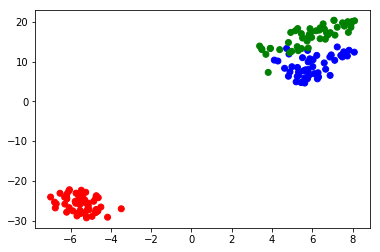

In [46]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TNSE on Text BOW vectors

In [47]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
# BoW vector = final_bigram_counts
import numpy as np
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn TSNE takes dense matrix as input converting sparse matrix to dense matrix


x = final_bigram_counts.todense()
y = final['Score'].values

tsne_BoW = TSNE(n_components=2, random_state=1, perplexity=perplexity, n_iter = iterations, learning_rate =learningrate)
t0 = time.time()

TSNE_X = tsne_BoW.fit_transform(x)
print("Time Elapsed in BoW TSNE {} seconds".format(time.time()-t0))

Time Elapsed in BoW TSNE 341.2294719219208 seconds


In [48]:




final['Score'].value_counts()


1    2500
0    2500
Name: Score, dtype: int64

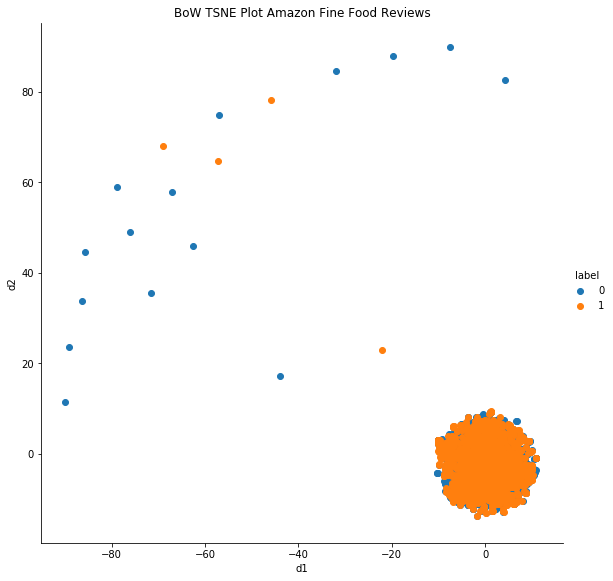

(5000, 3)

In [49]:
import seaborn as sns

tsne_df_bow = pd.DataFrame(data=TSNE_X, columns=('d1', 'd2'))
tsne_df_bow['label'] = final['Score'].values
sns.FacetGrid(tsne_df_bow, hue='label', height=8).map(plt.scatter, 'd1', 'd2').add_legend()
plt.title('BoW TSNE Plot Amazon Fine Food Reviews')

plt.show()
tsne_df_bow.shape

## [5.1] Applying TNSE on Text TFIDF vectors

In [50]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
# TFIDF vector = final_tf_idf
import numpy as np
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time

# sklearn TSNE takes dense matrix as input converting sparse matrix to dense matrix

x = final_tf_idf.todense()
y = final['Score'].values

tsne_TFIDF = TSNE(n_components=2, random_state=1, perplexity=perplexity, n_iter = iterations, learning_rate =learningrate)
t0 = time.time()

TSNE_X = tsne_TFIDF.fit_transform(x)
print("Time Elapsed in TFIDF TSNE {} seconds".format(time.time()-t0))    




Time Elapsed in TFIDF TSNE 258.1767580509186 seconds


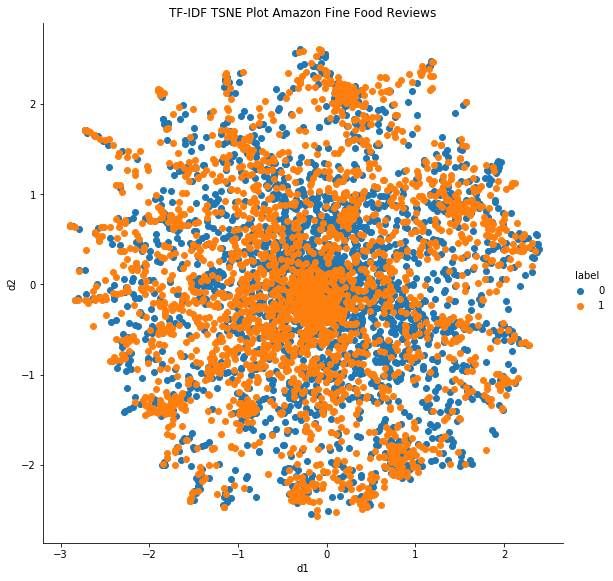

(5000, 3)

In [51]:
import seaborn as sns

tsne_df_tfidf = pd.DataFrame(data=TSNE_X, columns=('d1', 'd2'))
tsne_df_tfidf['label'] = final['Score'].values
sns.FacetGrid(tsne_df_tfidf, hue='label', height=8).map(plt.scatter, 'd1', 'd2').add_legend()
plt.title('TF-IDF TSNE Plot Amazon Fine Food Reviews')

plt.show()
tsne_df_tfidf.shape

## [5.3] Applying TNSE on Text Avg W2V vectors

In [52]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
# avg w2v vector = sent_vectors
import numpy as np
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time


x = sent_vectors
y = final['Score'].values

tsne_AVGW2V = TSNE(n_components=2, random_state=1, perplexity=perplexity, n_iter = iterations, learning_rate =learningrate)
t0 = time.time()

TSNE_X = tsne_AVGW2V.fit_transform(x)
print("Time Elapsed in AVG W2V TSNE {} seconds".format(time.time()-t0))    
   
    

Time Elapsed in AVG W2V TSNE 171.34181022644043 seconds


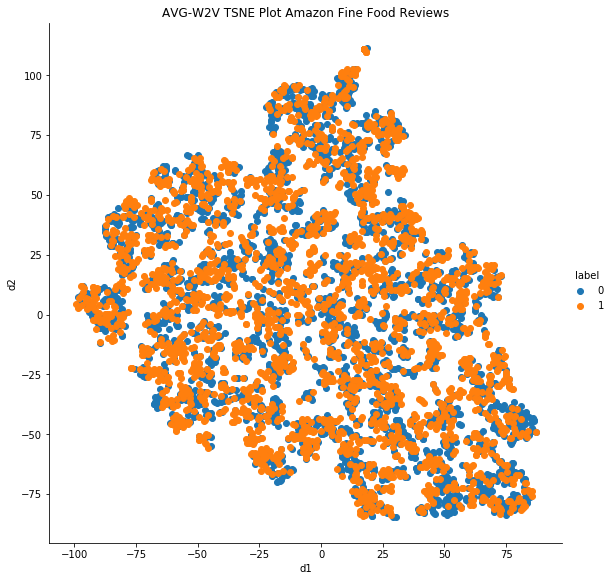

(5000, 3)

In [53]:
import seaborn as sns

tsne_df_avgw2v = pd.DataFrame(data=TSNE_X, columns=('d1', 'd2'))
tsne_df_avgw2v['label'] = final['Score'].values
sns.FacetGrid(tsne_df_avgw2v, hue='label', height=8).map(plt.scatter, 'd1', 'd2').add_legend()
plt.title('AVG-W2V TSNE Plot Amazon Fine Food Reviews')

plt.show()
tsne_df_avgw2v.shape

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [54]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
 
#TFIDF weighted W2V vector = tfidf_sent_vectors
import numpy as np
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
import time


x = tfidf_sent_vectors
y = final['Score'].values

tsne_TFIDFW2V = TSNE(n_components=2, random_state=1, perplexity=perplexity, n_iter = iterations, learning_rate =learningrate)
t0 = time.time()

TSNE_X = tsne_TFIDFW2V.fit_transform(x)
print("Time Elapsed in TFIDF W2V TSNE {} seconds".format(time.time()-t0))    
   
    
    

Time Elapsed in TFIDF W2V TSNE 179.6267409324646 seconds


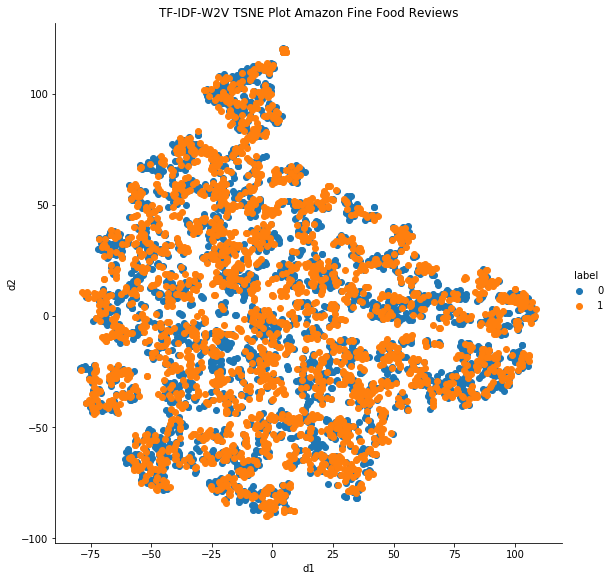

(5000, 3)

In [55]:
import seaborn as sns

tsne_df_tfidfw2v = pd.DataFrame(data=TSNE_X, columns=('d1', 'd2'))
tsne_df_tfidfw2v['label'] = final['Score'].values
sns.FacetGrid(tsne_df_tfidfw2v, hue='label', height=8).map(plt.scatter, 'd1', 'd2').add_legend()
plt.title('TF-IDF-W2V TSNE Plot Amazon Fine Food Reviews')

plt.show()
tsne_df_tfidfw2v.shape

# [6] Conclusions

In [0]:
# Lets save our hardworked and lots of time consumed tsne dataframes
import datetime
import os
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M')
directory = "drive/My\ Drive/tsne_{}-per-{}-iter-{}-data-{}/".format(st, perplexity, iterations, totaldatapoints)

tsne_df_bow.to_csv(r'tsne_df_bow.csv')
tsne_df_tfidf.to_csv(r'tsne_df_tfidf.csv')
tsne_df_avgw2v.to_csv(r'tsne_df_avgw2v.csv')
tsne_df_tfidfw2v.to_csv(r'tsne_df_tfidfw2v.csv')

!mkdir $directory
!cp tsne_df_bow.csv $directory
!cp tsne_df_tfidf.csv $directory
!cp tsne_df_avgw2v.csv $directory
!cp tsne_df_tfidfw2v.csv $directory


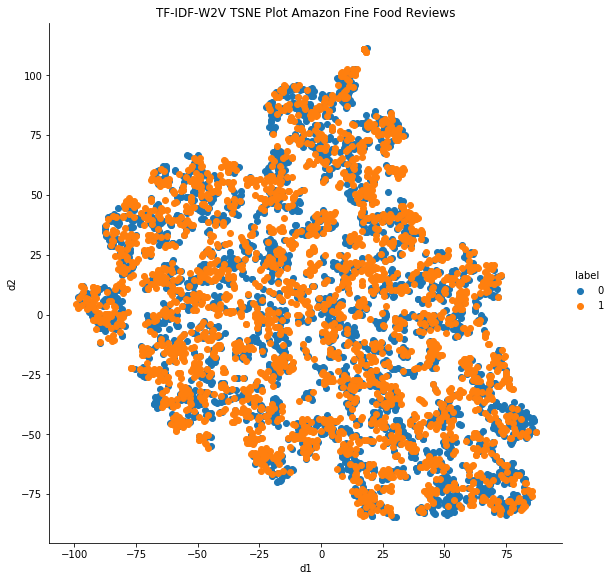

In [57]:
tsne_df_tfidfw2v = pd.DataFrame(data=pd.read_csv('tsne_df_avgw2v.csv'), columns=('d1', 'd2'))
tsne_df_tfidfw2v['label'] = final['Score'].values
sns.FacetGrid(tsne_df_tfidfw2v, hue='label', height=8).map(plt.scatter, 'd1', 'd2').add_legend()
plt.title('TF-IDF-W2V TSNE Plot Amazon Fine Food Reviews')

plt.show()


# Write few sentance about the results that you got and observation that you did from the analysis

We are using only 5000 datapoints here with perplexity 20 and iterations=5000
We have used equal datapoints of positive and negative reviews so that there is no partiality with either positive or negative review and one cannot dominate on the other
We have shuffled the final dataframe of 5000 datapoints so that every datapoint will crete an independent change in the model.

1. BoW TSNE cannot be utilised to separate positive reviews from negative reviews. It is less reliable in my thoughts because of several outliers in the plot.
2. The more the number of iteration the better the TSNE plot is getting
3. Neither BoW, TF-IDF, AVG-W2V or TF-IDF-W2V can distinguish between positive and negative review in such a way that we can simply draw a hyperplane
4. We need to check for more values of perplexity to get better results